#### Getting Started with BinsceneA

This notebook shows how to load the BinsceneA dataset in PyTorch, what kind of samples it contains and how they can be visualized and transformed.

In [1]:
import torch
import random
import matplotlib.pyplot as plt
from dataset_util.dataset import BinsceneA

In [2]:
# create an instance of the BinsceneA dataset
binscene_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='full', premultiply_alpha=True)
# display some information on the dataset
print(f'The dataset contains {len(binscene_dataset)} samples.')
print(f'It contains objects from the following {len(binscene_dataset.class_labels)} classes:')
print(binscene_dataset.class_labels, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(binscene_dataset))
# 
img_tensor, object_visibility_vector = binscene_dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(binscene_dataset, batch_size=64,
                                          shuffle=True, num_workers=2)
print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of an object visibility vector is:', object_visibility_vector.shape)

The dataset contains 200000 samples.
It contains objects from the following 17 classes:
['cracker_box' 'sugar_box' 'mustard_bottle' 'potted_meat_can' 'banana'
 'bleach_cleanser' 'mug' 'sponge' 'spatula' 'power_drill' 'wood_block'
 'extra_large_clamp' 'softball' 'golf_ball' 'dice' 'toy_airplane'
 'red_box'] 

The shape of an image tensor is: torch.Size([3, 360, 640])
The shape of an object visibility vector is: torch.Size([17])


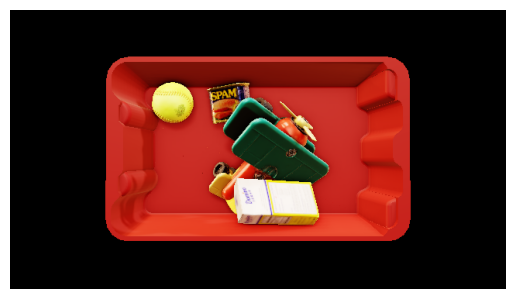

Visible objects are potted_meat_can, red_box, softball, sugar_box and toy_airplane.


In [3]:
# we can also have the dataset visualize and describe a sample
fig, ax = plt.subplots()
ax, image_description = binscene_dataset.show(img_tensor, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

#### Transforms

Just like any PyTorch [VisionDataset](https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html), the binscene datasets accept custom *transforms*, *transform* and *target_transform*. The cell below illustrates this by resizing the images when they are loaded. For more information about transforming data, see the [PyTorch Docs](https://pytorch.org/vision/main/transforms.html).

The shape of the image tensor is: torch.Size([3, 256, 384]) tensor(0.) tensor(1.)
The shape of the object visibility vector is: torch.Size([17])


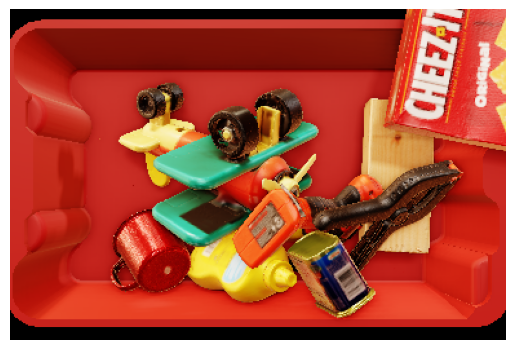

Visible objects are banana, cracker_box, extra_large_clamp, mug, mustard_bottle, potted_meat_can, power_drill, red_box, toy_airplane and wood_block.


In [4]:
import torchvision
# we don't need this module to warn us about all kinds of stuff
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import Resize, CenterCrop, Compose

# transform is applied to the images, target transform is applied to the visibility vectors
# transformS is applied to a tuple of (image, visibility vector)
# These functions can be defined and chained as desired, but they expect torch tensors as inputs

# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
resize_transform = Resize(size=(90, 160), antialias=True)
crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
image_transform = Compose([resize_transform, crop_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='train', premultiply_alpha=True, 
                                transform=crop_transform)
trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=128,
                                          shuffle=True, num_workers=12,pin_memory=True)
# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset))
img_tensor, object_visibility_vector = transformed_dataset.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape)
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset.show(img_tensor, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

The shape of the image tensor is: torch.Size([3, 256, 384]) tensor(0.) tensor(0.9961)
The shape of the object visibility vector is: torch.Size([17])


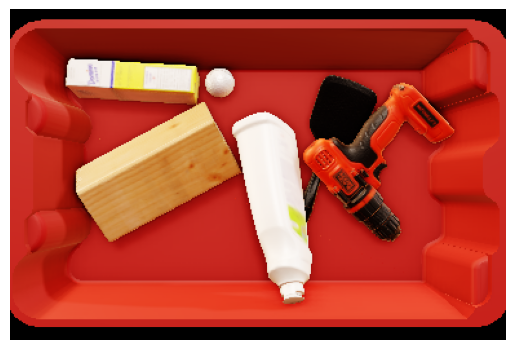

Visible objects are bleach_cleanser, golf_ball, power_drill, red_box, spatula, sugar_box and wood_block.


In [5]:
# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
resize_transform = Resize(size=(90, 160), antialias=True)
crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
image_transform = Compose([resize_transform, crop_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='train', premultiply_alpha=True, 
                                transform=crop_transform)
trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=128,
                                          shuffle=True, num_workers=12,pin_memory=True)
# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset))
img_tensor, object_visibility_vector = transformed_dataset.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape)
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset.show(img_tensor, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv2 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(512 * 4, num_classes)

        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * 4, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [9]:
def ResNetWithParam(img_channel=3, num_classes=17):
    return ResNet(ResidualBlock, [1, 1, 1, 1], img_channel, num_classes)

In [10]:
def test():
    BATCH_SIZE = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNetWithParam(img_channel=3, num_classes=17).to(device)
    y = net(torch.randn(BATCH_SIZE, 3, 360, 640, device=device))
    assert y.size() == torch.Size([BATCH_SIZE, 17])
    print(y.size())

In [11]:
test()

torch.Size([4, 17])


In [12]:
learning_rate = 0.02

model = ResNetWithParam(img_channel=3, num_classes=17).to(device)
criterion = nn.SmoothL1Loss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=256, verbose=True)

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0

In [14]:

￼
￼
￼
￼
from tqdm.auto import tqdm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
best_loss = 1e25
for epoch in range(2):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
    # get the inputs; data is a list of [inputs, labels]
        img_tensors, class_labels = [t.to(device) for t in data]
        class_labels = class_labels.squeeze(1).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(img_tensors)
        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()
        scheduler.step(loss.item())

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}, best loss: {best_loss:.3f}')
            running_loss = 0.0
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), 'best_model.pt')
print('Finished Training')

10it [00:07,  3.22it/s]

[1,    10] loss: 0.182, best loss: 0.123


21it [00:11,  4.45it/s]

[1,    20] loss: 0.119, best loss: 0.114


31it [00:13,  5.47it/s]

[1,    30] loss: 0.116, best loss: 0.110


41it [00:16,  4.43it/s]

[1,    40] loss: 0.109, best loss: 0.096


50it [00:19,  3.09it/s]

[1,    50] loss: 0.099, best loss: 0.088


60it [00:21,  4.95it/s]

[1,    60] loss: 0.099, best loss: 0.087


71it [00:24,  5.56it/s]

[1,    70] loss: 0.108, best loss: 0.087


81it [00:27,  5.04it/s]

[1,    80] loss: 0.109, best loss: 0.087


90it [00:30,  4.02it/s]

[1,    90] loss: 0.097, best loss: 0.087


101it [00:33,  3.69it/s]

[1,   100] loss: 0.098, best loss: 0.082


110it [00:37,  1.65it/s]

[1,   110] loss: 0.087, best loss: 0.082


120it [00:38,  5.42it/s]

[1,   120] loss: 0.089, best loss: 0.082


131it [00:42,  5.55it/s]

[1,   130] loss: 0.089, best loss: 0.082


141it [00:44,  5.25it/s]

[1,   140] loss: 0.092, best loss: 0.082


151it [00:48,  3.97it/s]

[1,   150] loss: 0.090, best loss: 0.081


161it [00:50,  3.84it/s]

[1,   160] loss: 0.088, best loss: 0.081


170it [00:53,  3.01it/s]

[1,   170] loss: 0.091, best loss: 0.081


180it [00:55,  5.23it/s]

[1,   180] loss: 0.088, best loss: 0.081


191it [00:58,  4.96it/s]

[1,   190] loss: 0.087, best loss: 0.081


201it [01:02,  4.12it/s]

[1,   200] loss: 0.086, best loss: 0.080


211it [01:04,  4.98it/s]

[1,   210] loss: 0.088, best loss: 0.080


221it [01:07,  3.26it/s]

[1,   220] loss: 0.088, best loss: 0.080


230it [01:09,  2.65it/s]

[1,   230] loss: 0.087, best loss: 0.080


240it [01:11,  5.44it/s]

[1,   240] loss: 0.088, best loss: 0.080


251it [01:14,  5.49it/s]

[1,   250] loss: 0.087, best loss: 0.080


261it [01:18,  4.28it/s]

[1,   260] loss: 0.088, best loss: 0.080


271it [01:21,  3.76it/s]

[1,   270] loss: 0.089, best loss: 0.080


281it [01:24,  3.12it/s]

[1,   280] loss: 0.088, best loss: 0.080


290it [01:25,  4.73it/s]

[1,   290] loss: 0.086, best loss: 0.080


300it [01:29,  5.21it/s]

[1,   300] loss: 0.087, best loss: 0.080


311it [01:33,  4.53it/s]

[1,   310] loss: 0.087, best loss: 0.080


321it [01:37,  4.15it/s]

[1,   320] loss: 0.087, best loss: 0.080


331it [01:40,  4.28it/s]

[1,   330] loss: 0.084, best loss: 0.080


341it [01:43,  2.84it/s]

[1,   340] loss: 0.086, best loss: 0.080


350it [01:45,  4.32it/s]

[1,   350] loss: 0.087, best loss: 0.080


360it [01:48,  5.06it/s]

[1,   360] loss: 0.087, best loss: 0.080


371it [01:51,  4.67it/s]

[1,   370] loss: 0.086, best loss: 0.080


381it [01:54,  3.38it/s]

[1,   380] loss: 0.086, best loss: 0.080


391it [01:57,  2.57it/s]

[1,   390] loss: 0.088, best loss: 0.080


401it [02:00,  3.78it/s]

[1,   400] loss: 0.085, best loss: 0.080


410it [02:02,  5.05it/s]

[1,   410] loss: 0.089, best loss: 0.080


421it [02:06,  4.70it/s]

[1,   420] loss: 0.086, best loss: 0.080


431it [02:09,  4.18it/s]

[1,   430] loss: 0.088, best loss: 0.080


441it [02:12,  4.40it/s]

[1,   440] loss: 0.087, best loss: 0.080


451it [02:15,  2.81it/s]

[1,   450] loss: 0.089, best loss: 0.080


461it [02:18,  4.09it/s]

[1,   460] loss: 0.087, best loss: 0.080


470it [02:20,  5.31it/s]

[1,   470] loss: 0.086, best loss: 0.080


481it [02:23,  5.34it/s]

[1,   480] loss: 0.089, best loss: 0.080


491it [02:27,  4.47it/s]

[1,   490] loss: 0.087, best loss: 0.080


501it [02:30,  4.38it/s]

[1,   500] loss: 0.087, best loss: 0.080


511it [02:32,  4.25it/s]

[1,   510] loss: 0.087, best loss: 0.080


521it [02:35,  2.83it/s]

[1,   520] loss: 0.089, best loss: 0.080


530it [02:37,  5.44it/s]

[1,   530] loss: 0.087, best loss: 0.080


541it [02:41,  5.44it/s]

[1,   540] loss: 0.102, best loss: 0.080


551it [02:45,  4.45it/s]

[1,   550] loss: 0.092, best loss: 0.080


561it [02:48,  4.60it/s]

[1,   560] loss: 0.088, best loss: 0.080


570it [02:51,  3.02it/s]

[1,   570] loss: 0.088, best loss: 0.080


581it [02:53,  4.31it/s]

[1,   580] loss: 0.087, best loss: 0.079


590it [02:55,  5.54it/s]

[1,   590] loss: 0.090, best loss: 0.079


601it [02:58,  5.37it/s]

[1,   600] loss: 0.087, best loss: 0.079


611it [03:01,  5.01it/s]

[1,   610] loss: 0.088, best loss: 0.079


621it [03:04,  4.67it/s]

[1,   620] loss: 0.087, best loss: 0.079


631it [03:07,  4.13it/s]

[1,   630] loss: 0.087, best loss: 0.079


641it [03:10,  3.01it/s]

[1,   640] loss: 0.088, best loss: 0.079


650it [03:11,  5.53it/s]

[1,   650] loss: 0.087, best loss: 0.079


661it [03:14,  5.50it/s]

[1,   660] loss: 0.087, best loss: 0.079


671it [03:18,  4.85it/s]

[1,   670] loss: 0.087, best loss: 0.079


681it [03:21,  3.96it/s]

[1,   680] loss: 0.089, best loss: 0.079


691it [03:24,  3.06it/s]

[1,   690] loss: 0.085, best loss: 0.079


701it [03:29,  1.76it/s]

[1,   700] loss: 0.087, best loss: 0.079


710it [03:30,  5.17it/s]

[1,   710] loss: 0.085, best loss: 0.079


721it [03:33,  5.53it/s]

[1,   720] loss: 0.087, best loss: 0.079


731it [03:37,  4.97it/s]

[1,   730] loss: 0.087, best loss: 0.079


741it [03:40,  4.50it/s]

[1,   740] loss: 0.088, best loss: 0.078


751it [03:44,  3.13it/s]

[1,   750] loss: 0.085, best loss: 0.078


761it [03:46,  3.26it/s]

[1,   760] loss: 0.087, best loss: 0.078


770it [03:48,  5.43it/s]

[1,   770] loss: 0.088, best loss: 0.078


781it [03:52,  4.94it/s]

[1,   780] loss: 0.088, best loss: 0.078


791it [03:57,  4.38it/s]

[1,   790] loss: 0.088, best loss: 0.078


801it [04:01,  4.45it/s]

[1,   800] loss: 0.086, best loss: 0.078


811it [04:05,  2.87it/s]

[1,   810] loss: 0.087, best loss: 0.078


821it [04:07,  3.30it/s]

[1,   820] loss: 0.087, best loss: 0.078


830it [04:09,  5.61it/s]

[1,   830] loss: 0.086, best loss: 0.078


841it [04:13,  5.05it/s]

[1,   840] loss: 0.086, best loss: 0.078


851it [04:16,  4.46it/s]

[1,   850] loss: 0.087, best loss: 0.078


861it [04:20,  3.75it/s]

[1,   860] loss: 0.087, best loss: 0.078


871it [04:23,  3.51it/s]

[1,   870] loss: 0.087, best loss: 0.078


881it [04:27,  2.19it/s]

[1,   880] loss: 0.089, best loss: 0.078


890it [04:29,  5.41it/s]

[1,   890] loss: 0.087, best loss: 0.078


901it [04:31,  5.61it/s]

[1,   900] loss: 0.089, best loss: 0.078


911it [04:35,  4.72it/s]

[1,   910] loss: 0.086, best loss: 0.078


921it [04:39,  3.79it/s]

[1,   920] loss: 0.088, best loss: 0.078


931it [04:41,  4.42it/s]

[1,   930] loss: 0.087, best loss: 0.078


941it [04:45,  2.02it/s]

[1,   940] loss: 0.087, best loss: 0.078


950it [04:46,  5.40it/s]

[1,   950] loss: 0.087, best loss: 0.078


961it [04:50,  5.41it/s]

[1,   960] loss: 0.088, best loss: 0.078


971it [04:54,  4.66it/s]

[1,   970] loss: 0.086, best loss: 0.078


981it [04:57,  4.70it/s]

[1,   980] loss: 0.087, best loss: 0.078


991it [05:01,  2.89it/s]

[1,   990] loss: 0.087, best loss: 0.078


993it [05:02,  3.88it/s]

Epoch 00992: reducing learning rate of group 0 to 1.0000e-02.


1001it [05:05,  2.18it/s]

[1,  1000] loss: 0.086, best loss: 0.078


1010it [05:07,  5.12it/s]

[1,  1010] loss: 0.086, best loss: 0.078


1021it [05:09,  5.34it/s]

[1,  1020] loss: 0.087, best loss: 0.078


1031it [05:13,  4.81it/s]

[1,  1030] loss: 0.087, best loss: 0.078


1041it [05:16,  4.67it/s]

[1,  1040] loss: 0.088, best loss: 0.078


1051it [05:19,  3.95it/s]

[1,  1050] loss: 0.086, best loss: 0.078


1061it [05:22,  2.04it/s]

[1,  1060] loss: 0.087, best loss: 0.078


1070it [05:24,  5.52it/s]

[1,  1070] loss: 0.088, best loss: 0.078


1081it [05:26,  5.71it/s]

[1,  1080] loss: 0.087, best loss: 0.078


1091it [05:30,  5.04it/s]

[1,  1090] loss: 0.087, best loss: 0.078


1101it [05:33,  4.22it/s]

[1,  1100] loss: 0.086, best loss: 0.078


1111it [05:37,  2.85it/s]

[1,  1110] loss: 0.086, best loss: 0.078


1121it [05:40,  2.81it/s]

[1,  1120] loss: 0.087, best loss: 0.078


1130it [05:42,  5.60it/s]

[1,  1130] loss: 0.087, best loss: 0.078


1141it [05:45,  5.54it/s]

[1,  1140] loss: 0.086, best loss: 0.078


1151it [05:49,  4.70it/s]

[1,  1150] loss: 0.087, best loss: 0.078


1161it [05:51,  5.10it/s]

[1,  1160] loss: 0.088, best loss: 0.078


1171it [05:55,  3.61it/s]

[1,  1170] loss: 0.086, best loss: 0.078


1181it [05:59,  1.92it/s]

[1,  1180] loss: 0.086, best loss: 0.078


1190it [06:00,  5.29it/s]

[1,  1190] loss: 0.085, best loss: 0.078


1201it [06:03,  5.61it/s]

[1,  1200] loss: 0.086, best loss: 0.078


1211it [06:06,  5.12it/s]

[1,  1210] loss: 0.084, best loss: 0.078


1221it [06:10,  4.45it/s]

[1,  1220] loss: 0.084, best loss: 0.078


1231it [06:13,  3.63it/s]

[1,  1230] loss: 0.086, best loss: 0.078


1241it [06:15,  4.85it/s]

[1,  1240] loss: 0.086, best loss: 0.078


1250it [06:17,  3.31it/s]

[1,  1250] loss: 0.087, best loss: 0.078



11it [00:07,  4.59it/s]

[2,    10] loss: 0.086, best loss: 0.078


21it [00:12,  4.49it/s]

[2,    20] loss: 0.087, best loss: 0.078


31it [00:15,  4.85it/s]

[2,    30] loss: 0.086, best loss: 0.078


41it [00:19,  2.91it/s]

[2,    40] loss: 0.087, best loss: 0.078


51it [00:23,  2.21it/s]

[2,    50] loss: 0.084, best loss: 0.078


60it [00:24,  5.65it/s]

[2,    60] loss: 0.085, best loss: 0.078


71it [00:29,  5.28it/s]

[2,    70] loss: 0.086, best loss: 0.078


77it [00:33,  2.31it/s]


KeyboardInterrupt: 

The shape of the image tensor is: torch.Size([3, 256, 384]) tensor(0.) tensor(1.)
The shape of the object visibility vector is: torch.Size([17]) torch.BoolTensor


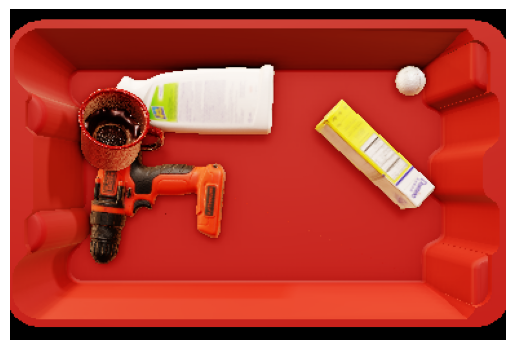

Visible objects are bleach_cleanser, golf_ball, mug, power_drill, red_box and sugar_box.
tensor([False,  True, False, False, False,  True,  True, False, False,  True,
        False, False, False,  True, False, False,  True])
tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False,  True,  True, False,  True])
tensor([ True, False,  True,  True,  True, False, False, False,  True, False,
         True,  True,  True,  True, False,  True,  True]) tensor(0.6471)


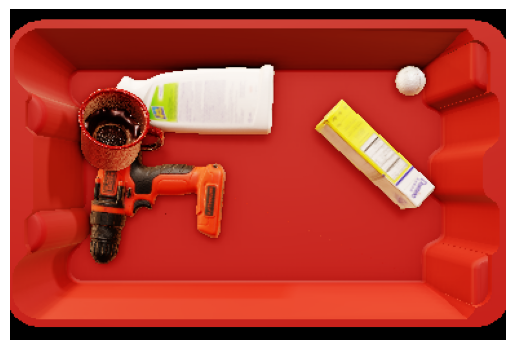

Model output
Visible objects are dice, golf_ball, red_box and sponge.


In [32]:
# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
#resize_transform = Resize(size=(90, 160), antialias=True)
#crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
#image_transform = Compose([resize_transform, crop_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset_valid = BinsceneA(root='/data/BinsceneA_16_objects', split='val', premultiply_alpha=True, 
                                transform=crop_transform)
#trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=128,
#                                          shuffle=True, num_workers=12,pin_memory=True)
# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset_valid))
img_tensor, object_visibility_vector = transformed_dataset_valid.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape, object_visibility_vector.type())
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset_valid.show(img_tensor, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

#print(object_visibility_vector.shape)
model.eval()
with torch.no_grad():
    pred = model(img_tensor.unsqueeze(0).to(device)).cpu().squeeze(0)
    #pred = torch.sigmoid(pred)
    pred = (pred > 0.3) #.int()

    
print(object_visibility_vector)
print(pred)
print(object_visibility_vector == pred, (object_visibility_vector == pred).sum()/17.)

fig, ax = plt.subplots()
ax, image_description_prediction = transformed_dataset_valid.show(img_tensor, pred, ax)
plt.axis('off')
plt.show()
print('Model output')
print(image_description_prediction)

